## 1. Seleccionar dos conjuntos de datos y unificarlos teniendo en cuenta que nuestro conjunto base es el de los alquileres.

In [13]:
import pandas as pd
alquiler_df = pd.read_csv('/content/drive/MyDrive/Hackathon/2017_lloguer_preu_trim.csv')
accidentes_df = pd.read_csv('/content/drive/MyDrive/Hackathon/2017_accidents_causa_conductor_gu_bcn_.csv')
ruido_df = pd.read_csv('/content/drive/MyDrive/Hackathon/2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv')

In [14]:
alquiler_df.head()


,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,2017,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,2017,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26
2,2017,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78
3,2017,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),895.28
4,2017,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),871.08


In [15]:
ruido_df.head()


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38%
3,1,Ciutat Vella,1,el Raval,TOTAL_D,50-55 dB,11.97%
4,1,Ciutat Vella,1,el Raval,TOTAL_D,55-60 dB,19.85%


In [21]:
# Unificar el conjunto de datos de alquileres con el conjunto de datos de accidentes
merged_final = pd.merge(alquiler_df, ruido_df,
                                     on=['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri'],
                                      how='left')

# Mostrar las primeras filas del conjunto de datos unificado
merged_final.head()


merged_final = merged_final.drop('Preu', axis=1)

print(merged_final.head())

    Any  Trimestre  Codi_Districte Nom_Districte  Codi_Barri Nom_Barri  \
0  2017          1               1  Ciutat Vella           1  el Raval   
1  2017          1               1  Ciutat Vella           1  el Raval   
2  2017          1               1  Ciutat Vella           1  el Raval   
3  2017          1               1  Ciutat Vella           1  el Raval   
4  2017          1               1  Ciutat Vella           1  el Raval   

                       Lloguer_mitja Concepte Rang_soroll   Valor  
0  Lloguer mitjà mensual (Euros/mes)  TOTAL_D      <40 dB   7.73%  
1  Lloguer mitjà mensual (Euros/mes)  TOTAL_D    40-45 dB  26.98%  
2  Lloguer mitjà mensual (Euros/mes)  TOTAL_D    45-50 dB   7.38%  
3  Lloguer mitjà mensual (Euros/mes)  TOTAL_D    50-55 dB  11.97%  
4  Lloguer mitjà mensual (Euros/mes)  TOTAL_D    55-60 dB  19.85%  


## 2. Realizar el preprocesamiento de datos necesario para garantizar que los datos sean precisos.

In [22]:
# Verificar valores nulos
null_values = merged_final.isnull().sum()
print(null_values)


Any               0
Trimestre         0
Codi_Districte    0
Nom_Districte     0
Codi_Barri        0
Nom_Barri         0
Lloguer_mitja     0
Concepte          0
Rang_soroll       0
Valor             0
dtype: int64


### Estandarización y Normalización

In [23]:
# Convertir la columna Valor a formato numérico
merged_final['Valor'] = merged_final['Valor'].str.rstrip('%').astype('float') / 100.0


In [24]:
from sklearn.preprocessing import StandardScaler

# Seleccionar solo las columnas numéricas para PCA
data_for_pca = merged_final.select_dtypes(include=[float, int])

# Estandarizar los datos
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_for_pca)


## 3. Aplicar un análisis de componentes principales para reducir las dimensiones del conjunto de datos.

In [25]:
from sklearn.decomposition import PCA

# Inicializar PCA
pca = PCA()

# Ajustar PCA a los datos estandarizados
principal_components = pca.fit_transform(data_standardized)


### Visualizar la varianza explicada por cada componente:

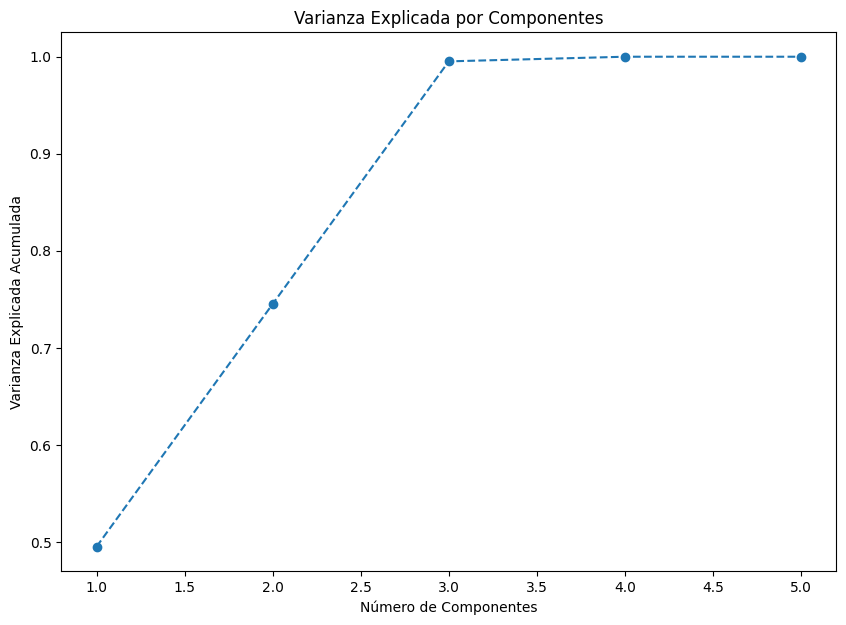

In [26]:
import matplotlib.pyplot as plt

# Varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10,7))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Varianza Explicada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.show()


¿Qué nos dice esto?

El primer componente es bastante significativo, ya que por sí solo puede explicar la mitad de la varianza en los datos.
Con solo los dos primeros componentes, podemos explicar el 75% de la varianza en los datos, lo que es bastante alto.

¿Qué podemos concluir?

Si nuestro objetivo es reducir la dimensionalidad de los datos sin perder mucha información, podríamos considerar usar solo los dos primeros componentes, ya que juntos explican el 75% de la varianza.
Si queremos conservar más información (a expensas de tener una mayor dimensionalidad), podríamos considerar usar más componentes.

In [27]:
# Obtener las cargas de las variables para los componentes
components = pca.components_

# Para el primer componente principal
first_component = components[0]
sorted_indices_first = first_component.argsort()[::-1]  # Ordenar de mayor a menor

# Para el segundo componente principal
second_component = components[1]
sorted_indices_second = second_component.argsort()[::-1]  # Ordenar de mayor a menor

# Imprimir las variables en orden de importancia para cada componente
print("Variables más influyentes para el primer componente principal:")
for index in sorted_indices_first:
    print(data_for_pca.columns[index], first_component[index])

print("\nVariables más influyentes para el segundo componente principal:")
for index in sorted_indices_second:
    print(data_for_pca.columns[index], second_component[index])


Variables más influyentes para el primer componente principal:
Any -0.0
Valor -7.28583859910259e-17
Trimestre -9.992007221626409e-16
Codi_Districte -0.7071067811865468
Codi_Barri -0.7071067811865482

Variables más influyentes para el segundo componente principal:
Valor 0.9973590939311572
Codi_Districte 1.1102230246251565e-16
Any 0.0
Codi_Barri -1.1449174941446927e-16
Trimestre -0.07262807826743876


## Conclusion

### Primer Componente Principal:
Las variables Codi_Districte y Codi_Barri tienen las cargas más altas (en valor absoluto) para este componente. Esto significa que estas dos variables son las que más influyen en la formación de este componente principal. Dado que sus cargas tienen valores similares y signos opuestos, esto indica que estas dos variables están inversamente relacionadas en este componente.
Las variables Any, Valor y Trimestre tienen cargas cercanas a cero, lo que indica que tienen una influencia mínima en este componente.
### Segundo Componente Principal:
La variable Valor tiene la carga más alta, lo que indica que es la más influyente en este componente principal.
La variable Trimestre tiene una carga negativa, aunque es bastante pequeña en comparación con la de Valor. Esto indica que Trimestre también influye en este componente, pero en menor medida.
Las variables Any, Codi_Districte y Codi_Barri tienen cargas cercanas a cero en este componente, lo que indica que su influencia es mínima.
### Conclusiones Generales:
El primer componente principal parece estar principalmente influenciado por las variables geográficas (Codi_Districte y Codi_Barri).
El segundo componente principal está dominado por la variable Valor, lo que indica que esta variable es esencial para capturar la variabilidad en los datos en esta dirección.
Las otras variables tienen una influencia relativamente baja en estos dos componentes.

Esto nos da una idea de las dimensiones o direcciones en las que los datos tienen la mayor variabilidad. Si estás interesado en analizar o modelar la variabilidad geográfica en tus datos, el primer componente principal sería el más relevante. Si estás más interesado en la variabilidad relacionada con el valor, el segundo componente principal sería el más pertinente.